https://medium.com/@chongdashu/papers-decoded-imagic-text-based-real-image-editing-with-diffusion-models-b1bda8b2532a

In [ ]:
%pip install numpy
%pip install matplotlib
%pip install fastai
%pip install accelerate
%pip install -U transformers diffusers ftfy
%pip install torch
%pip install torchvision
%pip install opencv-python
%pip install ipywidgets

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import inspect

from pathlib import Path

import numpy as np
import torch
from accelerate import Accelerator
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDIMScheduler,
    DPMSolverMultistepScheduler,
)
from huggingface_hub import notebook_login
from PIL import Image
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from typing import Optional

notebook_login()

In [ ]:
# Set seed
torch.manual_seed(3)

# (From the paper) VAE scale term to get closer to unit variance
vae_magic = 0.18215

# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("DongKyung/Imagic") #replace your own unet such as ("stabilityai/stable-diffusion-2-1", subfolder="unet")
diffusion_scheduler = DPMSolverMultistepScheduler.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="scheduler")

# Use GPU, if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

In [ ]:
def load_image(path: Path) -> Image.Image:
    return Image.open(path).convert("RGB")

def load_image_as_tensor(path: Path, size: int = 512, batch_dimension: bool = True) -> torch.Tensor:
    """
    Load image and convert to a resized tensor of values [-1, +1]
    """
    image = load_image(path)
    transform = tfms.Compose(
        [
            tfms.Resize(size),
            tfms.CenterCrop(size),
            tfms.ToTensor(),
        ]
    )
    transformed_image = transform(image)
    if batch_dimension:
        transformed_image = transformed_image.unsqueeze(0)

    return 2.0 * transformed_image - 1.0

def image2latent(im: Image.Image):
    im = tfms.ToTensor()(im).unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(im.to(device) * 2 - 1)
    return latent.latent_dist.sample() * vae_magic

def latents2images(latents):
    latents = latents / vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs * 255).round().astype("uint8")
    imgs = [Image.fromarray(i) for i in imgs]
    return imgs

def get_embedding_for_prompt(prompt: str, grad: bool = False) -> torch.Tensor:
    max_length = tokenizer.model_max_length
    tokens = tokenizer([prompt], padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
    tokens = tokens.input_ids.to(device)

    if grad:
        embedding = text_encoder(tokens)[0]
        embedding.requires_grad_(True)
    else:
        with torch.no_grad():
            embedding = text_encoder(tokens)[0]

    return embedding

@torch.no_grad()
def generate_image_from_text_embedding(
    text_embedding: torch.Tensor,
    num_inference_steps: int = 50,
    height: int = 512,
    width: int = 512,
    generator: Optional[torch.Generator] = None,
    guidance_scale: float = 7.5,
    eta: float = 0.0,
    init: Optional[torch.Tensor] = None,
) -> Image.Image:
    do_classifier_free_guidance = guidance_scale > 1.0
    # Determine start_step based on whether an initial latent is provided
    start_step = 10 if init is not None else 0

    if do_classifier_free_guidance:
        uncond_prompt = ""
        uncond_tokens = tokenizer(
            uncond_prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        uncond_embedding = text_encoder(uncond_tokens.input_ids.to(device))[0]

        # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
        uncond_embeddings = uncond_embedding.view(
            1,  # batch size
            uncond_embedding.shape[1],  # sequence length
            -1,
        )

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        text_embedding = torch.cat([uncond_embeddings, text_embedding])

    latents_shape = (1, unet.config.in_channels, height // 8, width // 8)
    latents_dtype = text_embedding.dtype

    if device.type == "mps":
        # rand doesn't exist on mps
        latents = torch.randn(latents_shape, device="cpu", generator=generator, dtype=latents_dtype).to(device)
    else:
        latents = torch.randn(latents_shape, device=device, generator=generator, dtype=latents_dtype)

    diffusion_scheduler.set_timesteps(num_inference_steps)

    if init is None:
        latents *= diffusion_scheduler.init_noise_sigma
    else:
        noise = torch.randn_like(init)
        latents = diffusion_scheduler.add_noise(init, noise, timesteps=torch.tensor([diffusion_scheduler.timesteps[start_step]]))
        latents = latents.to(device).float()

    # Prepare extra kwargs for the scheduler step
    accepts_eta = "eta" in set(inspect.signature(diffusion_scheduler.step).parameters.keys())
    extra_step_kwargs = {"eta": eta} if accepts_eta else {}

    progress = tqdm(enumerate(diffusion_scheduler.timesteps), total=num_inference_steps)
    progress.set_description("Generating Image")

    for index, timestep in progress:
        # Adjust the diffusion process based on start_step
        if index >= start_step:
            # Expand latents for classifier-free guidance if applicable
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = diffusion_scheduler.scale_model_input(latent_model_input, timestep)

            # Predict noise and apply guidance
            noise_pred = unet(latent_model_input, timestep, encoder_hidden_states=text_embedding)["sample"]
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            latents = diffusion_scheduler.step(noise_pred, timestep, latents, **extra_step_kwargs).prev_sample

    return latents2images(latents)[0]

In [ ]:
prompt = "A photo of flower are fluttering"

# Create embedding from prompt
text_embedding = get_embedding_for_prompt(prompt, grad=True)

# Prepare the text embedding for optimisation step later
text_embedding = torch.nn.Parameter(text_embedding)
text_embedding = text_embedding.detach()
text_embedding.requires_grad_()

tensor([[[-0.3134, -0.4476, -0.0082,  ...,  0.2542, -0.0324, -0.2960],
         [ 0.1996, -1.6936, -0.8946,  ...,  0.4658, -0.0956, -2.1484],
         [ 1.0237, -0.7343, -2.5376,  ...,  0.8944, -0.0588, -1.0715],
         ...,
         [ 0.5106, -1.7712, -0.2390,  ...,  0.0526, -0.5349,  0.2207],
         [ 0.5546, -1.7942, -0.2491,  ..., -0.2520, -0.5877,  0.3410],
         [ 0.3991, -2.4116, -0.7871,  ..., -0.1435, -0.6899,  0.7642]]],
       device='cuda:0', requires_grad=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#init_image 즉, 인풋용 이미지 만드는 셀

init_image = load_image(path="/content/drive/MyDrive/Imagic/flowers.png") #fill your own directory


  0%|          | 0/50 [00:00<?, ?it/s]

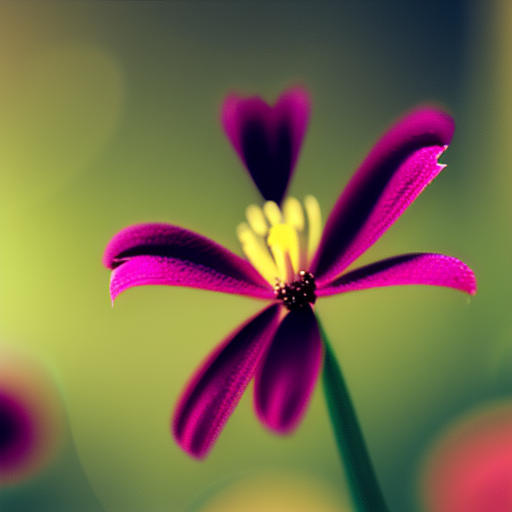

In [ ]:
# make a copy of the text embedding
og_embedding = text_embedding.clone()

# feed into our model and see what it comes up with
img = generate_image_from_text_embedding(og_embedding)

file_path = '/content/drive/MyDrive/Imagic/from_og_embedding.png' #fill your own directory
img.save(file_path, format='PNG')
Image.open('/content/drive/MyDrive/Imagic/from_og_embedding.png') #fill your own directory

In [ ]:
init_image_latent = image2latent(init_image)

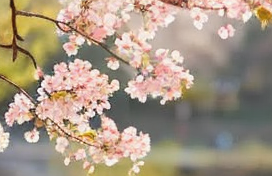

In [ ]:
og_latent = init_image_latent.clone()
og_imgs = latents2images(og_latent)#본문에서 오타난듯. image2latent --> latents2images 위 셀에서 latent로 만든걸 디코딩 해서 이미지로 만들어야 하기 때문.

file_path = '/content/drive/MyDrive/Imagic/og_image_no_text_embedding.png' #fill your own directory
og_imgs[0].save(file_path, format='PNG')
Image.open('/content/drive/MyDrive/Imagic/og_image_no_text_embedding.png') #fill your own directory

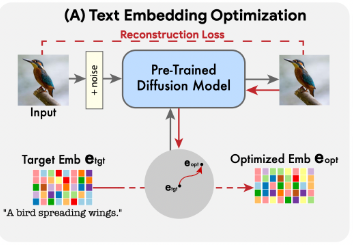

# 아래 코드는 위의 Text Emedding Optimization을 하는 cell
training 1

In [ ]:
import torch.optim as optim

# Define learning rate and number of iterations
lr = 0.001
it = 1000

# Initialize the optimizer for updating the embedding
opt = optim.Adam( #Adam -> AdamW
    [text_embedding],  # only optimise the embedding
    lr=lr,

)

# Define the loss criterion
criteria = torch.nn.MSELoss()

# Initialize a list to store the loss history
history = []

# Create a progress bar
progress = tqdm(range(it))
progress.set_description("steps")


diffusion_scheduler.set_timesteps(1000) # reset #본문에서 오타난듯. scheduler -> diffusion_scheduler 로 바꿨음.

# Prepare an accelerator to help with the training
accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision="fp16",
)
if accelerator.is_main_process:
    accelerator.init_trackers(
        "imagic",
        config={
            "embedding_learning_rate": lr,
            "text_embedding_optimization_steps": it,
        },
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Perform the training
for _ in progress:
    with accelerator.accumulate(text_embedding):
        noise = torch.randn_like(init_image_latent).to(device)
        timesteps = torch.randint(1000, (1,), device=device)

        noisy_latent = diffusion_scheduler.add_noise(init_image_latent, noise, timesteps=timesteps)

        noise_pred = unet(noisy_latent, timesteps, text_embedding).sample

        loss = criteria(noise_pred, noise)
        accelerator.backward(loss)

        opt.step()
        opt.zero_grad()

    if accelerator.sync_gradients:
        # Checks if the accelerator has performed an optimization step behind the scenes
        progress.update(1)

    progress.set_postfix({"loss": loss.item()})

accelerator.wait_for_everyone()


In [ ]:
img = generate_image_from_text_embedding(text_embedding)

file_path = '/content/drive/MyDrive/Imagic/after_text_embedding_optimization.png' #fill your own directory
img.save(file_path, format='PNG')
Image.open('/content/drive/MyDrive/Imagic/after_text_embedding_optimization.png') #fill your own directory

  0%|          | 0/50 [00:00<?, ?it/s]

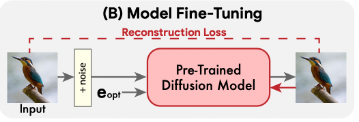

# 아래 코드는 위의 Model Fine-Tuning을 하는 cell
training 2


In [ ]:
text_embedding.requires_grad_(False) # fix the text embedding

lr = 0.001
it = 1500

unet.requires_grad_(True)
unet.train()
opt = optim.AdamW(
    unet.parameters(),  # optimise unet parameters
    lr=lr,
)
criteria = torch.nn.MSELoss()

diffusion_scheduler.set_timesteps(1000) # reset #본문에서 오타난듯. scheduler -> diffusion_scheduler 로 바꿨음.

In [ ]:
progress = tqdm(range(it))
for _ in progress:
    with accelerator.accumulate(unet.parameters()):
        noise = torch.randn_like(init_image_latent).to(device)
        timesteps = torch.randint(1000, (1,), device=device)
        noisy_latent = diffusion_scheduler.add_noise(init_image_latent, noise, timesteps)

        noise_pred = unet(noisy_latent, timesteps, text_embedding).sample

        loss = criteria(noise_pred, noise)
        accelerator.backward(loss)

        opt.step()
        opt.zero_grad()

    if accelerator.sync_gradients:
        # Checks if the accelerator has performed an optimization step behind the scenes
        progress.update(1)

    progress.set_postfix({"loss": loss.item()})

accelerator.wait_for_everyone()


# 모델 체크포인트 생성 및 업로드

In [ ]:
repo_name = "Imagic"  # Replace with your repository name
repo_id = "DongKyung/Imagic" #fill your own directory

# Push the model to the hub
unet.push_to_hub(repo_id=repo_id)

print(f"Model pushed to {repo_id}")

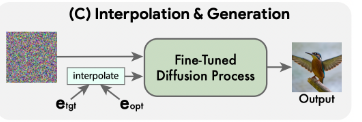

#학습이 끝난 뒤 사용하는 단계


In [ ]:
from PIL import Image
for alpha in (0.0, 0.5, 0.75, 1, 1.25):
  new_emb = alpha*og_embedding + (1-alpha)*text_embedding
  img = generate_image_from_text_embedding(new_emb,init = init_image_latent)
  file_path = f'/content/drive/MyDrive/Imagic/after_text_embedding_optimization_and_fine_tuning{alpha}.png' #fill your own directory
  img.save(file_path, format='PNG')
  Image.open(file_path)

In [ ]:
def generate_images_60_alphas(og_embedding, text_embedding, init_image_latent):
    """
    알파 값 0.0부터 1.0까지 60개의 동일한 간격으로 나누고, 각 알파 값마다 새로운 임베딩을 계산하고 이미지를 생성합니다.

    :param og_embedding: 원래 임베딩 벡터.
    :param text_embedding: 텍스트 임베딩 벡터.
    :param init_image_latent: 초기 이미지 잠재 공간.
    :param generate_image_from_text_embedding: 임베딩을 입력으로 받아 이미지를 생성하는 함수.
    :return: 생성된 이미지 객체들의 리스트.
    """
    # 알파 값 0.0부터 1.0까지 60개의 동일한 간격으로 나누기
    alphas = np.linspace(0.0, 1.0, 60)

    # 이미지 객체를 저장할 리스트
    images = []

    # 각 알파 값마다 새로운 임베딩을 계산하고 이미지를 생성
    for alpha in alphas:
        # 새로운 임베딩 계산
        new_emb = alpha * og_embedding + (1 - alpha) * text_embedding

        # 새로운 임베딩을 사용하여 이미지 생성
        img = generate_image_from_text_embedding(new_emb,init = init_image_latent)

        # 생성된 이미지를 리스트에 추가
        images.append(img)

    return images

def create_gif_from_images(images, gif_filename, duration=1000//60):
    """
    주어진 이미지 목록을 사용하여 GIF를 생성합니다.

    :param images: `PIL.Image` 객체로 구성된 이미지 목록.
    :param gif_filename: 생성할 GIF 파일의 이름.
    :param duration: 각 프레임의 지속 시간 (밀리초).
    """
    # duration = 1000 (1초) // 60 (fps)
    # GIF 생성
    images[0].save(
        gif_filename,
        save_all=True,
        append_images=images[1:],
        duration=duration,
        loop=0
    )

    return images[0]

images = generate_images_60_alphas(og_embedding, text_embedding,init_image_latent = init_image_latent)
gif = create_gif_from_images(images,'/content/drive/MyDrive/Imagic/result.gif') #fill your own directory

gif = Image.open('/content/drive/MyDrive/Imagic/result.gif') #fill your own directory
